In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
import random

import cv2
import sqlite3

from tensorflow import keras

from tensorflow.keras import applications, models
from tensorflow.keras.layers import Dense, BatchNormalization

import glob

import seaborn as sns

In [2]:
# seq2 = models.Sequential()
# trained_model = applications.InceptionV3(weights="imagenet")
# seq2.add(trained_model)
# module = applications.inception_v3
# width, height = 299, 299

# module = applications.inception_v3

In [3]:
images_path = "countries/data/flags/PNG-128/"

In [4]:
trained_model = applications.InceptionV3(weights="imagenet")
module = applications.inception_v3
width, height = 299, 299

df = pd.read_sql_table("Countries", "sqlite:///countries/data/sqlite/countries.db")

images = []
images_raw = []
masks = []
images_orig = []
for fname in df["flag_128"]:
    #print(fname)
    file_path = os.path.join(images_path, fname)
    img = mpimage.imread(file_path)
    images_orig.append(img)
    if img.shape[2] == 4:
        mask = img[:, :, 3]
        img = img[:, :, :3]
    else:
        mask = np.ones(img.shape[:2])
    #img = cv2.resize(img, (width, height))
    images_raw.append(img.copy())
    #print(img.shape)
    img = module.preprocess_input(img)
    images.append(img)
    masks.append(mask)
images = np.stack(images)
masks = np.stack(masks)
masks = np.transpose(np.array([masks] * 3), axes=(1, 2, 3, 0))

n_classes = images.shape[0]
y = np.identity(n_classes)

In [5]:
assert df.notnull().all().all()

for col in ['code3l', 'code2l', 'name', 'name_official', 'flag_32',
       'flag_128']:
    assert (df[col].value_counts() == 1).all()

In [6]:
all_backgrounds = glob.glob("val2017/*.jpg")
backgrounds_raw = [mpimage.imread(img_file) for img_file in all_backgrounds[:1000]]
backgrounds = [module.preprocess_input(x / 256) for x in backgrounds_raw if (len(x.shape) == 3) & (x.shape[0] >= width) & (x.shape[1] >= height)]

In [7]:
def create_model():
    
    #head_layers = [n_classes * 4, n_classes * 2]

    trained_model = applications.InceptionV3(weights="imagenet")
    module = applications.inception_v3

    head_layers = []
    layer_inner = trained_model.layers[-2].output

    for n_nodes in head_layers:
        layer_inner = Dense(n_nodes, activation="relu")(layer_inner)

    last_layer = Dense(n_classes, activation="softmax")(layer_inner)

    seq2 = models.Model(inputs=trained_model.input, outputs=last_layer)

    for layer in seq2.layers:
        if layer.name.find("batch_normalization") != -1:
            layer.trainable = False
    return seq2

In [ ]:
seq2 = create_model()

In [9]:
seq2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
train_share = 0.7

idx_train_imgs = random.sample(range(n_classes), int(n_classes * train_share))
idx_test_imgs = list(set(range(n_classes)).difference(idx_train_imgs))

n_backgrounds = len(backgrounds)
idx_train_backgrounds = random.sample(range(n_backgrounds), int(n_backgrounds * train_share))
idx_test_backgrounds = set(range(n_backgrounds)).difference(idx_train_backgrounds)

In [9]:
train_images = images[idx_train_imgs]
test_images = images[idx_test_imgs]

train_masks = masks[idx_train_imgs]
test_masks = masks[idx_test_imgs]

train_backgrounds = [backgrounds[i] for i in idx_train_backgrounds]
test_backgrounds = [backgrounds[i] for i in idx_test_backgrounds]

In [10]:
all([len(x.shape) == 3 for x in train_backgrounds]), all([x.shape[2] == 3 for x in train_backgrounds])

(True, True)

In [11]:
# def train_gen_overlay(batch_size, backgrounds, images, masks):
    
#     assert len(images) == len(masks)
#     while True:
        
#         background_idx = random.randint(0, len(backgrounds) - 1)
#         background = backgrounds[background_idx]
#         # cut a random window of size width x height from the selected backgrounf
#         x0, y0 = random.randint(0, background.shape[0] - width), random.randint(0, background.shape[1] - height)
#         background = background[x0: x0 + width, y0: y0 + height]
        
#         # create a random batch of images
#         sample = random.choices(range(len(images)), k=batch_size)
#         #sample = [0]
#         imgs_sample = images[sample]
#         masks_sample = masks[sample]
#         imgs_width, imgs_height = masks_sample.shape[1:-1]
        
#         overlayed = background.copy()
#         overlayed = np.array([overlayed] * len(sample))
#         # select a random position in the background window
#         x_img, y_img = (random.randint(0, background.shape[0] - imgs_width), 
#                         random.randint(0, background.shape[1] - imgs_height))
        
#         from_images = imgs_sample * masks_sample
#         from_background = overlayed[:, x_img: x_img + imgs_width, y_img: y_img + imgs_height] * (1 - masks_sample)
#         #from_background = np.array([from_background] * len(sample))
#         overlayed[:, x_img: x_img + imgs_width, y_img: y_img + imgs_height] = from_images + from_background
#         yield overlayed, y[sample]
        
        
        
def train_gen_overlay2(batch_size, backgrounds, images, masks, min_scale=1):
    
    assert len(images) == len(masks)
    while True:
        
        background_idx = random.randint(0, len(backgrounds) - 1)
        background = backgrounds[background_idx]
        if len(background.shape) != 3:
            print(background.shape)
            print(background_idx)
            
        # cut a random window of size width x height from the selected background
        x0, y0 = random.randint(0, background.shape[0] - width), random.randint(0, background.shape[1] - height)
        background = background[x0: x0 + width, y0: y0 + height]
        
        # create a random batch of images
        sample = random.choices(range(len(images)), k=batch_size)
        #sample = [0]
        imgs_sample = images[sample]
        masks_sample = masks[sample]
        
        imgs_trans, masks_trans = [], []
        
        max_scale_x = background.shape[0] / masks.shape[1]
        max_scale_y = background.shape[1] / masks.shape[2]
        max_scale = min(max_scale_x, max_scale_y)
        #print(f"max_scale {max_scale}")
        scale = np.random.rand() * (max_scale - min_scale) + min_scale
        #print(f"scale {scale}")
        for img, mask in zip(imgs_sample, masks_sample):
            img_trans, mask_trans = transform_image_mask(img, mask, scale)
            imgs_trans.append(img_trans)
            masks_trans.append(mask_trans)
            
        imgs_trans = np.array(imgs_trans)
        masks_trans = np.array(masks_trans)
        
        imgs_width, imgs_height = masks_trans.shape[1:-1]
        # select a random position in the background window
        x_img, y_img = (random.randint(0, background.shape[0] - imgs_width), 
                            random.randint(0, background.shape[1] - imgs_height))
    
        if len(background.shape) != 3:
            print(background.shape)
            print(background_idx)
            print(x0, y0)
            print(width, height)
        overlayed = lay_over_background(background, imgs_trans, masks_trans, x_img, y_img)
#         if random.random() < 0.1:
#             print("showing...")
#             plt.imshow((overlayed[0] * 0.5 + 0.5) * 255)
#             plt.show()
        yield overlayed, y[sample]
        

def lay_over_background(background, imgs_trans, masks_trans, x_img, y_img):
    
    overlayed = background.copy()
    overlayed = np.array([overlayed] * len(imgs_trans))
    
    imgs_width, imgs_height = imgs_trans.shape[1], imgs_trans.shape[2] 
    assert (imgs_width > 0) & (imgs_height > 0)
    from_images = imgs_trans * masks_trans
    
    if len(overlayed.shape) != 4:
        print(overlayed.shape)
        print(background.shape)
        print(imgs_trans.shape)
        print(x_img, y_img)
    assert len(overlayed.shape) == 4
    
    from_background = overlayed[:, x_img: x_img + imgs_width, y_img: y_img + imgs_height] * (1 - masks_trans)
    #from_background = np.array([from_background] * len(sample))
    overlayed[:, x_img: x_img + imgs_width, y_img: y_img + imgs_height] = from_images + from_background
    return overlayed
        
        
def transform_image_mask(img, mask, scale=2, brightness=(0.5, 2)):
    assert img.shape == mask.shape
    img_w = img.shape[0]
    img_h = img.shape[1]
    transf, img_h_new, img_w_new = get_random_transform(img_h, img_w, scale)
    out_mask = cv2.warpAffine(mask, transf, (img_h_new, img_w_new))
    out_img = cv2.warpAffine(img * 0.5 + 0.5, transf, (img_h_new, img_w_new))
    
    out_img *= np.random.rand() * (brightness[1] - brightness[0]) + brightness[0]
    
    out_img = (out_img - 0.5) * 2
    
    
    
    return out_img, out_mask

# def get_random_transform(img_w, img_h, alpha=0.2):
#     src = np.float32([(0, 0), (0, img_h), (img_w, 0)])
#     dst =  np.float32([rand_point(img_w, img_h), 
#                        rand_point(img_w, img_h), 
#                        rand_point(img_w, img_h)])
#     transf = cv2.getAffineTransform(src, dst)
    
#     return transf


def get_random_transform(img_w, img_h, scale, alpha=0.3):
    src = np.float32([(0, 0), (0, img_h), (img_w, 0)])
    max_shift_h = int(img_h * alpha)
    max_shift_w = int(img_w * alpha)
    dst = np.float32([(random.randint(0, max_shift_w), random.randint(0, max_shift_h)), 
                      (random.randint(0, max_shift_w), img_h - random.randint(0, max_shift_h)),
                      (img_w - random.randint(0, max_shift_w), random.randint(0, max_shift_h))])
    dst *= scale
    transf = cv2.getAffineTransform(src, dst)
    #sc_factor = max(dst[:, 1].max() / img_h, dst[:, 0].max() / img_w)
    #print(f"sc_factor {sc_factor}")
    return transf, int(img_w * scale), int(img_h * scale)


def rand_point(w, h):
    return random.randint(0, int(w)), random.randint(0, int(h))

In [12]:

# idx = 127
# img = images[idx]
# mask = masks[idx]
# out_img, out_mask = transform_image_mask(img, mask)

# plt.imshow((img * 0.5 + 0.5) * 255)
# plt.show()
# plt.imshow((out_img * 0.5 + 0.5) * 255)
# plt.show()
# plt.imshow(out_mask)
# plt.show()

In [15]:
train_steps = 8
batch_size = 128
train_gen = train_gen_overlay2(batch_size, train_backgrounds, images, masks)
test_gen = train_gen_overlay2(batch_size, test_backgrounds, images, masks)

lr = 0.001
seq2.compile(keras.optimizers.Adam(lr), loss="categorical_crossentropy", metrics=["accuracy"])
#seq2.summary()

In [18]:
trainable_params = sum([keras.backend.count_params(weight) for weight in seq2.trainable_weights])

In [19]:
rand_id = np.random.randint(10000)
n_layers = len(seq2.layers)
n_nodes_last = seq2.layers[-1].output_shape[1]
run_name = f"run_{head_layers}_cls_{n_nodes_last}_lr_{lr}_bs_{batch_size}_ts_{train_steps}_tp_{trainable_params}_{rand_id}"

In [20]:
run_name

'run_[]_cls_250_lr_0.001_bs_128_ts_8_tp_22263386_9415'

In [21]:
 #0.1 * 800 // batch_size
validation_steps = train_steps #int((1 - train_share) * train_steps)
print(f"train_steps={train_steps} \n\rvalidation_steps={validation_steps}")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"logs/{run_name}")
seq2.fit(train_gen, epochs=600,
         steps_per_epoch=train_steps, callbacks=[tensorboard_callback])

train_steps=8 
validation_steps=8
Epoch 1/600
1/8 [==>...........................] - ETA: 0s - loss: 5.6118 - accuracy: 0.0000e+00WARNING:tensorflow:From /Users/grisha.oryol/Documents/projects/opencv/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - 642s 80s/step - loss: 6.6379 - accuracy: 0.0049
Epoch 2/600
8/8 [==============================] - 911s 114s/step - loss: 5.5403 - accuracy: 0.0020
Epoch 3/600
8/8 [==============================] - 562s 70s/step - loss: 5.5255 - accuracy: 0.0039
Epoch 4/600
8/8 [==============================] - 620s 78s/step - loss: 5.5322 - accuracy: 0.0059
Epoch 5/600
8/8 [==============================] - 640s 80s/step - loss: 5.5296 - accuracy: 0.0068
Epoch 6/600
8/8 [==============================] - 694s 87s/step - loss: 

KeyboardInterrupt: 

In [22]:
seq2.save_weights(f"inception3_{run_name}.hdf5")

In [78]:
seq2 = create_model()
seq2.load_weights(f"inception3_{run_name}.hdf5")

In [12]:
run_load = "run_[]_cls_250_lr_0.001_bs_512_ts_8_8550"
seq3 = create_model()
seq3.load_weights(f"inception3_{run_load}.hdf5")

In [ ]:
train_steps = 1 # 8

run_load = "run_[]_cls_250_lr_0.001_bs_512_ts_8_8550"
seq4 = create_model()
seq4.load_weights(f"inception3_{run_load}.hdf5")


batch_size = 128
train_gen = train_gen_overlay2(batch_size, train_backgrounds, images, masks)
test_gen = train_gen_overlay2(batch_size, test_backgrounds, images, masks)

lr = 0.0001
seq4.compile(keras.optimizers.Adam(lr), loss="categorical_crossentropy", metrics=["accuracy"])

trainable_params = sum([keras.backend.count_params(weight) for weight in seq4.trainable_weights])
rand_id = np.random.randint(10000)
n_layers = len(seq4.layers)
n_nodes_last = seq4.layers[-1].output_shape[1]
head_layers = []
run_name = f"run_{head_layers}_cls_{n_nodes_last}_lr_{lr}_bs_{batch_size}_ts_{train_steps}_tp_{trainable_params}_{rand_id}"


print(f"train_steps={train_steps}")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"logs/{run_name}")
for _ in range(100):
    seq4.fit(train_gen, epochs=1,
             steps_per_epoch=train_steps, callbacks=[tensorboard_callback])
    diff_df = pd.DataFrame({w1.name: {"diff": avg_diff(w1.numpy(), w2.numpy()),
                                      "trainable": w1.trainable} for w1, w2 in zip(seq3.weights, 
                                                                                   seq4.weights)}).T
    display(diff_df[diff_df["diff"] > 0].sort_values(by="diff", ascending=False)[:5])

train_steps=1
1/1 [==============================] - 0s 96ms/step - loss: 5.6351 - accuracy: 0.1172


diff trainable
conv2d_147/kernel:0  1411.34      True
conv2d_184/kernel:0  437.815      True
conv2d_103/kernel:0  120.554      True
conv2d_142/kernel:0  101.913      True
conv2d_162/kernel:0  40.3246      True

1/1 [==============================] - 0s 21ms/step - loss: 37.3363 - accuracy: 0.0000e+00


diff trainable
conv2d_162/kernel:0  199.342      True
conv2d_105/kernel:0  109.866      True
conv2d_142/kernel:0  85.4665      True
conv2d_165/kernel:0  67.2708      True
conv2d_120/kernel:0  47.4521      True

1/1 [==============================] - 0s 26ms/step - loss: 18.7850 - accuracy: 0.0000e+00


diff trainable
conv2d_123/kernel:0  383.667      True
conv2d_168/kernel:0  179.879      True
conv2d_174/kernel:0  72.5424      True
conv2d_170/kernel:0  54.0807      True
conv2d_115/kernel:0  38.4192      True

1/1 [==============================] - 0s 20ms/step - loss: 16.4292 - accuracy: 0.0156


diff trainable
conv2d_170/kernel:0  3480.57      True
conv2d_156/kernel:0  1942.83      True
conv2d_107/kernel:0  200.435      True
conv2d_154/kernel:0  167.127      True
conv2d_120/kernel:0     95.8      True

1/1 [==============================] - 0s 60ms/step - loss: 12.5395 - accuracy: 0.0078


diff trainable
conv2d_106/kernel:0  11436.4      True
conv2d_134/kernel:0  118.917      True
conv2d_120/kernel:0  109.353      True
conv2d_146/kernel:0   102.24      True
conv2d_179/kernel:0  101.524      True

1/1 [==============================] - 0s 19ms/step - loss: 9.0800 - accuracy: 0.0000e+00


diff trainable
conv2d_181/kernel:0  479.954      True
conv2d_176/kernel:0  227.093      True
conv2d_125/kernel:0  70.4062      True
conv2d_127/kernel:0  61.3544      True
conv2d_182/kernel:0  51.7652      True

1/1 [==============================] - 0s 19ms/step - loss: 8.1475 - accuracy: 0.0000e+00


diff trainable
conv2d_135/kernel:0   804.93      True
conv2d_175/kernel:0  214.078      True
conv2d_130/kernel:0  125.897      True
conv2d_136/kernel:0  123.289      True
conv2d_167/kernel:0  120.942      True

1/1 [==============================] - 0s 24ms/step - loss: 7.3592 - accuracy: 0.0078


diff trainable
conv2d_120/kernel:0  203.672      True
conv2d_175/kernel:0  116.412      True
conv2d_181/kernel:0  75.1767      True
conv2d_182/kernel:0  73.6403      True
conv2d_180/kernel:0  65.2611      True

1/1 [==============================] - 0s 23ms/step - loss: 6.6329 - accuracy: 0.0000e+00


diff trainable
conv2d_183/kernel:0   6643.4      True
conv2d_184/kernel:0  450.892      True
conv2d_181/kernel:0  399.886      True
conv2d_174/kernel:0   197.44      True
conv2d_175/kernel:0  170.834      True

1/1 [==============================] - 0s 19ms/step - loss: 6.2162 - accuracy: 0.0078


diff trainable
conv2d_110/kernel:0  355.946      True
conv2d_175/kernel:0  275.989      True
conv2d_176/kernel:0  210.875      True
conv2d_116/kernel:0  130.734      True
conv2d_136/kernel:0  124.563      True

1/1 [==============================] - 0s 21ms/step - loss: 6.4072 - accuracy: 0.0000e+00


diff trainable
conv2d_136/kernel:0  1576.77      True
conv2d_184/kernel:0   536.51      True
conv2d_167/kernel:0  217.863      True
conv2d_118/kernel:0  192.725      True
conv2d_104/kernel:0  125.137      True

1/1 [==============================] - 0s 19ms/step - loss: 5.8868 - accuracy: 0.0000e+00


diff trainable
conv2d_165/kernel:0  671.348      True
conv2d_127/kernel:0  559.283      True
conv2d_131/kernel:0  469.472      True
conv2d_184/kernel:0  281.949      True
conv2d_176/kernel:0  87.8906      True

1/1 [==============================] - 0s 21ms/step - loss: 5.7578 - accuracy: 0.0078


diff trainable
conv2d_110/kernel:0  1539.45      True
conv2d_175/kernel:0  1075.83      True
conv2d_182/kernel:0  345.215      True
conv2d_184/kernel:0  256.158      True
conv2d_140/kernel:0  187.675      True

1/1 [==============================] - 0s 36ms/step - loss: 5.7368 - accuracy: 0.0000e+00


diff trainable
conv2d_180/kernel:0  1033.81      True
conv2d_132/kernel:0  371.596      True
conv2d_139/kernel:0  330.109      True
conv2d_184/kernel:0   144.71      True
conv2d_160/kernel:0  89.0648      True

1/1 [==============================] - 0s 18ms/step - loss: 5.7303 - accuracy: 0.0078


diff trainable
conv2d_120/kernel:0  334.492      True
conv2d_169/kernel:0  284.249      True
conv2d_168/kernel:0   249.36      True
conv2d_181/kernel:0  230.737      True
conv2d_184/kernel:0  141.098      True

1/1 [==============================] - 0s 105ms/step - loss: 5.5605 - accuracy: 0.0078


diff trainable
conv2d_185/kernel:0  424.947      True
conv2d_164/kernel:0   273.28      True
conv2d_186/kernel:0  223.236      True
conv2d_170/kernel:0  179.533      True
conv2d_138/kernel:0  147.217      True

1/1 [==============================] - 0s 23ms/step - loss: 5.6234 - accuracy: 0.0078


diff trainable
conv2d_152/kernel:0  6051.97      True
conv2d_156/kernel:0  2023.15      True
conv2d_175/kernel:0  831.208      True
conv2d_186/kernel:0  197.031      True
conv2d_180/kernel:0  194.054      True

1/1 [==============================] - 0s 19ms/step - loss: 5.6303 - accuracy: 0.0000e+00


diff trainable
conv2d_120/kernel:0  2791.23      True
conv2d_137/kernel:0  813.628      True
conv2d_164/kernel:0  759.073      True
conv2d_126/kernel:0  506.652      True
conv2d_161/kernel:0   408.63      True

1/1 [==============================] - 0s 19ms/step - loss: 5.6327 - accuracy: 0.0000e+00


diff trainable
conv2d_126/kernel:0  271.678      True
conv2d_167/kernel:0  148.091      True
conv2d_157/kernel:0    98.26      True
conv2d_182/kernel:0  82.5287      True
conv2d_184/kernel:0  82.3563      True

1/1 [==============================] - 0s 18ms/step - loss: 5.5951 - accuracy: 0.0156


diff trainable
conv2d_169/kernel:0  746.433      True
conv2d_131/kernel:0  205.508      True
conv2d_184/kernel:0  177.676      True
conv2d_141/kernel:0  173.525      True
conv2d_171/kernel:0   163.35      True

1/1 [==============================] - 0s 19ms/step - loss: 5.5763 - accuracy: 0.0078


diff trainable
conv2d_182/kernel:0  472.517      True
conv2d_129/kernel:0  413.588      True
conv2d_183/kernel:0  323.399      True
conv2d_174/kernel:0  151.007      True
conv2d_142/kernel:0  136.104      True

1/1 [==============================] - 0s 18ms/step - loss: 5.5173 - accuracy: 0.0000e+00


diff trainable
dense/kernel:0       57488.2      True
conv2d_174/kernel:0  3908.06      True
conv2d_175/kernel:0  1985.74      True
conv2d_182/kernel:0  830.224      True
conv2d_165/kernel:0  718.656      True

1/1 [==============================] - 0s 18ms/step - loss: 5.5338 - accuracy: 0.0000e+00


diff trainable
conv2d_178/kernel:0  1460.11      True
conv2d_120/kernel:0  913.271      True
conv2d_141/kernel:0  318.129      True
conv2d_184/kernel:0  231.293      True
conv2d_175/kernel:0  224.738      True

In [14]:
def avg_diff(w1, w2):
    return np.mean((w1 / w2 - 1) ** 2) ** 0.5

In [14]:
diff_df = pd.DataFrame({w1.name: {"diff": avg_diff(w1.numpy(), w2.numpy()),
                                  "trainable": w1.trainable} for w1, w2 in zip(seq3.weights, 
                                                                               seq4.weights)}).T
diff_df[diff_df["diff"] > 0].sort_values(by="diff", ascending=False)[:5]

NameError: name 'seq3' is not defined

In [96]:
pd.Series(diff_df.index).str.find("batch_normalization_1034") > -1

0      False
1       True
2       True
3       True
4      False
       ...  
373    False
374    False
375    False
376    False
377    False
Length: 378, dtype: bool

In [101]:
diff_df.loc[diff_df.index.str.find("batch_normalization") > -1]["diff"].abs().max()

0.0

In [38]:
seq3.weights[0].trainable

True

In [121]:
#keras.backend.set_learning_phase(0)

In [32]:
seq2.evaluate(x=train_gen, steps=1)

1/1 [==============================] - 0s 2ms/step - loss: 26.8228 - accuracy: 0.0000e+00


[26.822843551635742, 0.0]

In [135]:
seq2.evaluate(x=test_gen, batch_size=1)

9/9 [==============================] - 10s 1s/step - loss: 1.1745 - accuracy: 0.4931


[1.1745402812957764, 0.4930555522441864]

In [108]:
next_train = next(train_gen)

max_scale 2.3359375
scale 0.9458201586918412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


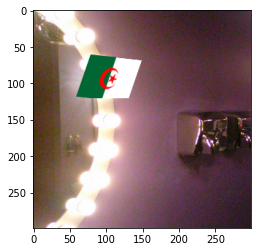

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


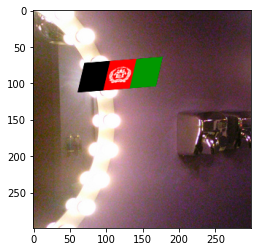

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


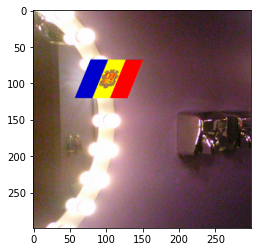

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


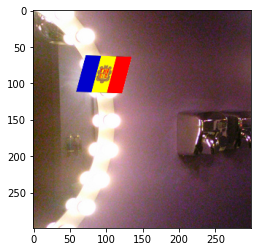

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


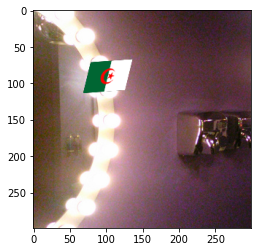

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


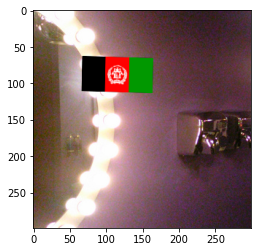

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


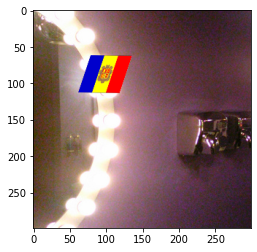

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


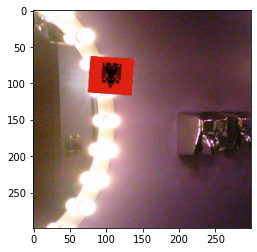

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


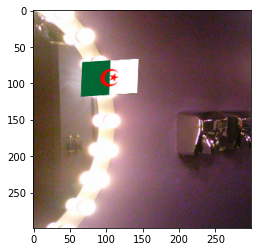

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


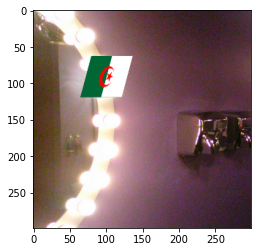

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


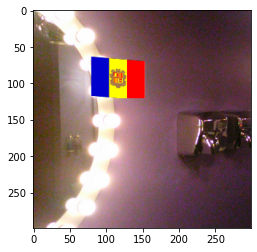

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


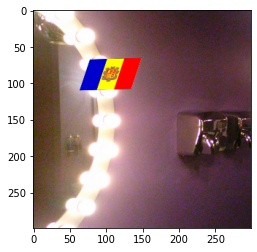

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


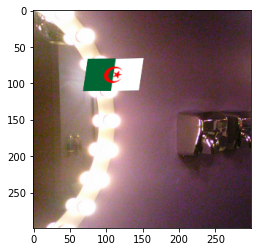

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


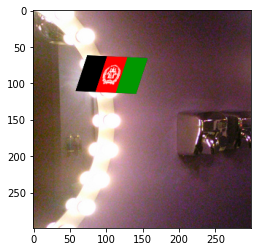

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


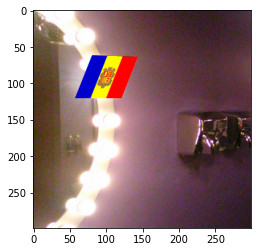

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


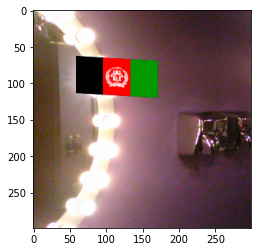

In [109]:
for im in next_train[0]:
    plt.imshow((im + 1) * 0.5 * 256)
    plt.show()

In [23]:
batch_size

512

In [19]:
accs = 0 
n_iter = 10
for i in range(n_iter):
    batch, y_batch = next(train_gen)
    preds_batch = seq2.predict(batch)
    mean_acc = preds_batch.argmax(axis=1) == y_batch.argmax(axis=1)
    print(mean_acc.mean())
    accs += mean_acc.sum()
accs / (batch_size * n_iter)

0.6875
0.5
0.375
0.75
0.25
0.375
0.25
1.0
0.1875
0.9375


0.53125

In [78]:
keras.backend.set_learning_phase(0)

In [15]:
run_load = "run_[]_cls_250_lr_0.001_bs_512_ts_8_8550"
seq4 = create_model()
seq4.load_weights(f"inception3_{run_load}.hdf5")

probs_bb = []
res_bb = []
images_test_bb = []

for j in range(10):
    print(j)
    batch, y_batch = next(train_gen)
    preds_one = seq4(batch, training=False).numpy()
    pred_one = preds_one.argmax(axis=1)
    y_one = y_batch.argmax(axis=1)
    res_bb.append(pd.DataFrame({"pred": pred_one, "y": y_one}))
    probs_bb.append(pd.DataFrame(preds_one))
    images_test_bb.append(batch)

res_bb = pd.concat(res_bb, ignore_index=True)
probs_bb = pd.concat(probs_bb, ignore_index=True)

res_bb["wrong"] = res_bb["pred"] != res_bb["y"]
res_bb["correct"] = res_bb["pred"] == res_bb["y"]
loss_bb = - np.log(probs_bb).values[np.arange(probs_bb.shape[0]), res_bb["y"].values]
res_bb["loss"] = loss_bb
res_bb["correct"].mean()

0
1
2
3
4
5
6
7
8
9


0.23359375

In [134]:
probs = []
res = []
images_test = []

for j in range(1):
    print(j)
    batch, y_batch = next(train_gen)
    for i in range(batch_size):
        preds_one = seq2(batch[[i]], training=False).numpy()
        pred_one = preds_one.argmax(axis=1)
        y_one = y_batch[[i]].argmax(axis=1)
        res.append(pd.DataFrame({"pred": pred_one, "y": y_one}))
        probs.append(pd.DataFrame(preds_one))
        images_test.append(batch)

res = pd.concat(res, ignore_index=True)
probs = pd.concat(probs, ignore_index=True)

0


In [135]:
res["wrong"] = res["pred"] != res["y"]
res["correct"] = res["pred"] == res["y"]
loss = - np.log(probs).values[np.arange(probs.shape[0]), res["y"].values]
res["loss"] = loss

In [136]:
res["correct"].mean()

0.015625

In [137]:
res

pred    y  wrong  correct       loss
0      20   29   True    False  21.174982
1      20  236   True    False  25.776819
2      20   61   True    False  24.478392
3      20  248   True    False  39.280052
4     132   56   True    False  17.481747
..    ...  ...    ...      ...        ...
123   204   38   True    False  20.275822
124    20    6   True    False  29.095629
125    20  165   True    False  16.992226
126    20  194   True    False  30.680170
127    20  239   True    False  37.021557

[128 rows x 5 columns]

In [26]:
res.groupby(["pred", "y"])["wrong"].count().mean()

1.2190476190476192

In [27]:
res.groupby(["pred", "y"])["wrong"].mean().sort_values(ascending=False)

pred  y  
246   242     True
26    52      True
52    227     True
      234     True
      239     True
             ...  
129   129    False
134   134    False
135   135    False
136   136    False
4     4      False
Name: wrong, Length: 420, dtype: bool

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


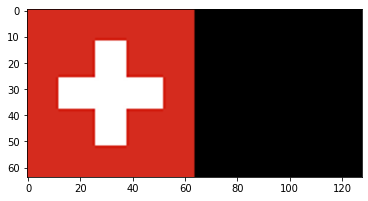

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


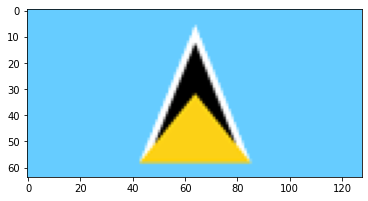

In [28]:
plt.imshow((images[158] + 1) * 0.5 * 256)
plt.show()
plt.imshow((images[136] + 1) * 0.5 * 256)
plt.show()

In [29]:
res.sort_values("loss", ascending=False)[:20]

pred    y  wrong  correct       loss
205   175   83   True    False  16.417248
65    190  119   True    False  14.442763
30     26   21   True    False  14.028050
134    26  197   True    False  13.742855
52     26   31   True    False  13.724235
373   175  241   True    False  13.598989
328    26  236   True    False  13.048111
47     45  199   True    False  12.512232
415    45   73   True    False  12.487067
207    79    9   True    False  12.020898
406    26  181   True    False  11.624253
102    26  157   True    False  11.549647
465   196  142   True    False  11.522796
363   175   95   True    False  11.521068
197    79  158   True    False  11.029557
418   175   71   True    False  11.024494
341   175  213   True    False  10.958937
172   175  241   True    False  10.944175
33     52  105   True    False  10.847101
492   196   50   True    False  10.773450

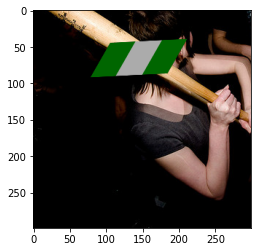

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


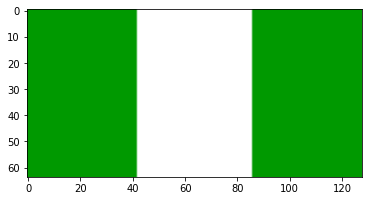

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


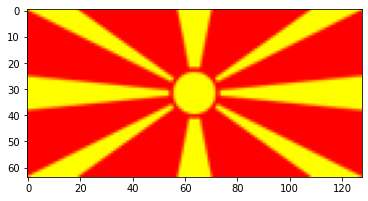

In [31]:
idx = 65
plt.imshow((images_test[idx][0] + 1) * 0.5 * 256)
plt.show()

plt.imshow((images[res.loc[idx]["y"]] + 1) * 0.5 * 256)
plt.show()

plt.imshow((images[res.loc[idx]["pred"]] + 1) * 0.5 * 256)
plt.show()

In [33]:
pd.DataFrame({"mean": res.groupby("y")["wrong"].mean(), "count": res.groupby("y")["wrong"].count()}).sort_values("mean")

mean  count
y               
48    0.0      1
79    0.0      2
190   0.0      1
226   0.0      2
64    0.0      2
..    ...    ...
106   1.0      2
107   1.0      3
108   1.0      1
95    1.0      3
247   1.0      2

[213 rows x 2 columns]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


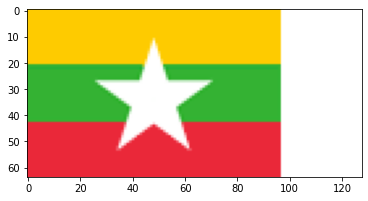

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


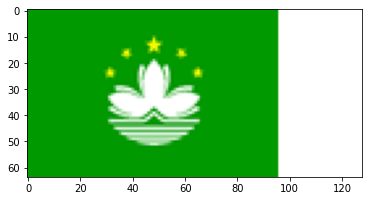

In [105]:
plt.imshow((images[111] + 1) * 0.5 * 256)
plt.show()

plt.imshow((images[223] + 1) * 0.5 * 256)
plt.show()

In [81]:
crosstab_abs[96].sort_values()

pred
0      0
160    0
161    0
162    0
163    0
      ..
182    1
114    2
199    2
32     2
223    4
Name: 96, Length: 196, dtype: int64

In [30]:
wrong_by_class = (res.groupby("y")["wrong"].sum() / res.shape[0])

In [31]:
pd.Series(wrong_by_class).sort_values(ascending=False)

y
61     0.006445
243    0.006055
65     0.006055
213    0.005859
210    0.005859
         ...   
190    0.001563
135    0.001367
17     0.001172
185    0.001172
151    0.000781
Name: wrong, Length: 250, dtype: float64

In [32]:
(res["pred"] == res["y"]).mean()

0.1419921875

In [34]:
crosstab_abs = pd.crosstab(res["pred"], res["y"])
crosstab = crosstab_abs.div(crosstab_abs.sum())

In [35]:
crosstab_abs.shape

(107, 213)

In [34]:
wrong_abs = crosstab_abs * (1 - np.eye(crosstab_abs.shape[0]))

ValueError: Unable to coerce to DataFrame, shape must be (196, 250): given (196, 196)

In [199]:
(wrong_abs.unstack().sort_values(ascending=False) / wrong_abs.sum().sum())[:10]

y   pred
14  15      0.028003
13  1       0.025055
6   7       0.024318
    9       0.022845
2   15      0.018423
3   15      0.016949
1   7       0.016212
    15      0.016212
15  14      0.015475
    3       0.015475
dtype: float64

In [36]:
largest2 = probs.T.apply(lambda x: x.sort_values().index[-2])
largest3 = probs.T.apply(lambda x: x.sort_values().index[-3])

In [37]:
(((res["y"] == res["pred"])).mean(), 
 ((res["y"] == largest2) | (res["y"] == res["pred"])).mean(),
((res["y"] == largest3) | (res["y"] == largest2) | (res["y"] == res["pred"])).mean(),
)

(0.21484375, 0.279296875, 0.337890625)

In [38]:
crosstab

y     0    1    2    3    4         5         6    7    8    9    ...  238  \
pred                                                              ...        
4     0.0  0.0  0.0  0.0  0.5  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
5     0.0  0.0  0.0  0.0  0.0  0.333333  0.000000  0.0  0.0  0.0  ...  0.0   
6     0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
8     0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.5  0.0  ...  0.0   
13    0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
...   ...  ...  ...  ...  ...       ...       ...  ...  ...  ...  ...  ...   
238   0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
240   0.0  0.0  0.0  0.0  0.5  0.333333  0.000000  0.0  0.0  0.0  ...  0.0   
242   0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
244   0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  ...  0.0   
246   0.0  0.0  0.0  0.0  0.0  0.000000  0.333333  0.0  0.0  0.0  ...  0.0   

y     239       240  241  242       243       244  245  246  247  
pred                                                              
4     0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
5     0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
6     0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
8     0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
13    0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
...   ...       ...  ...  ...       ...       ...  ...  ...  ...  
238   0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
240   0.0  0.333333  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  
242   0.0  0.000000  0.0  0.0  0.333333  0.000000  0.0  0.0  0.0  
244   0.0  0.000000  0.0  0.0  0.000000  0.166667  0.0  0.0  0.0  
246   0.0  0.000000  0.0  0.5  0.000000  0.000000  0.0  0.0  0.0  

[107 rows x 213 columns]

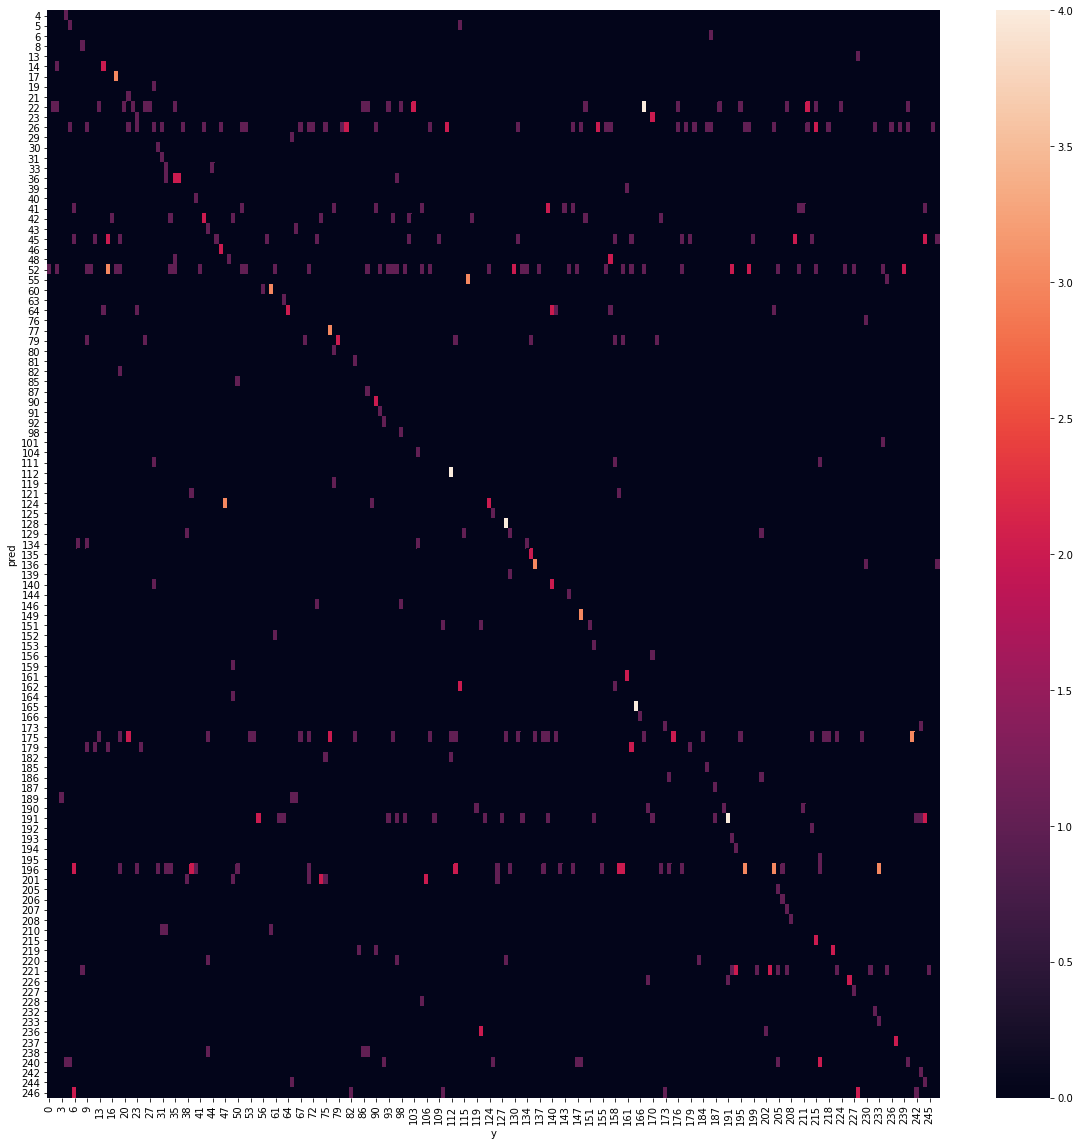

In [39]:
plt.figure(figsize=(20, 20))
sns.heatmap(crosstab_abs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


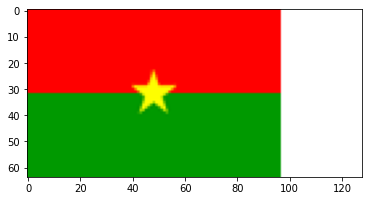

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


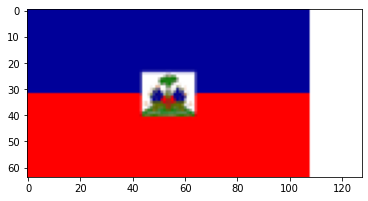

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


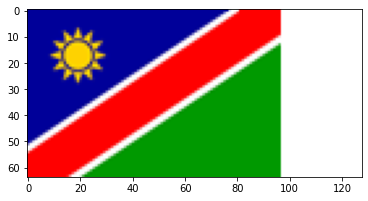

In [84]:
plt.imshow((images[25] + 1) * 0.5 * 256)
plt.show()
plt.imshow((images[69] + 1) * 0.5 * 256)
plt.show()
plt.imshow((images[112] + 1) * 0.5 * 256)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


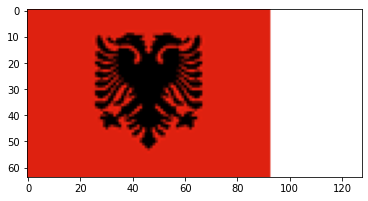

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


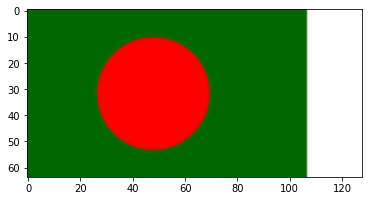

In [203]:
plt.imshow((images[1] + 1) * 0.5 * 256)
plt.show()
plt.imshow((images[13] + 1) * 0.5 * 256)

In [69]:
df.loc[13:16]

id  enabled code3l code2l        name                    name_official  \
13  14     True    BGD     BD  Bangladesh  People’s Republic of Bangladesh   
14  15     True    BRB     BB    Barbados                         Barbados   
15  16     True    BLR     BY     Belarus              Republic of Belarus   
16  17     True    BEL     BE     Belgium               Kingdom of Belgium   

      flag_32    flag_128     latitude     longitude  zoom  
13  BD-32.png  BD-128.png  24.08273251   90.49915527     7  
14  BB-32.png  BB-128.png  13.19383077  -59.54319600    11  
15  BY-32.png  BY-128.png  53.58628747   27.95338900     6  
16  BE-32.png  BE-128.png  50.49593874    4.46993600     8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.4375

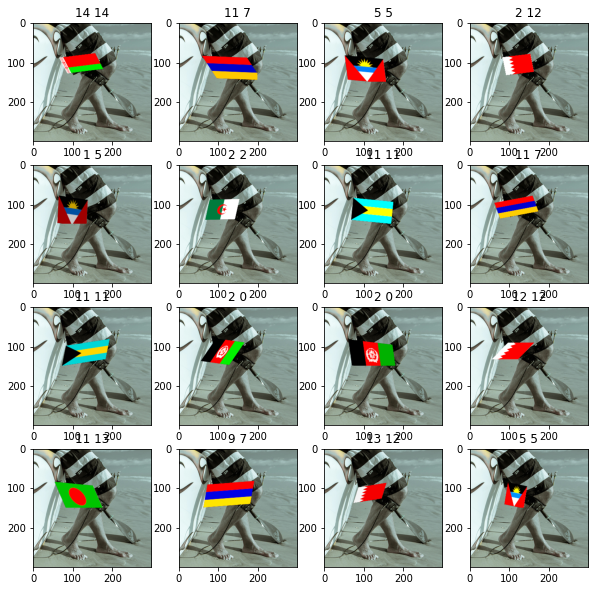

In [42]:
bs1 = 16
fig, axs = plt.subplots(bs1 // 4, 4, figsize=(10, 10))

batch, y_batch = next(train_gen)
res = []
for i in range(bs1):
    preds_one = seq2.predict(batch[[i]])[0]
    pred_one = preds_one.argmax()
    y_one = y_batch[[i]].argmax()
    #print(pred_one, y_one)
    res.append(pred_one == y_one)
    
    axs[i // 4, i % 4].imshow((batch[i] + 1) * 0.5 * 256)
    #assert ((batch[i] + 1) * 0.5 * 256).min() >= 0
    #assert ((batch[i] + 1) * 0.5 * 256).max() <= 1
    axs[i // 4, i % 4].set_title(f"{pred_one} {y_one}")
    
np.mean(res)

/Users/grisha.oryol/Documents/projects/opencv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


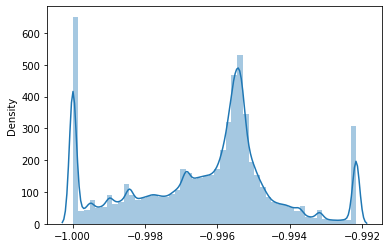

In [108]:
sns.distplot(batch)

In [104]:
import seaborn as sns

In [20]:
examples = ["albania_example.jpeg", "algeria_example_2.jpeg", "algeria_example.jpeg"]

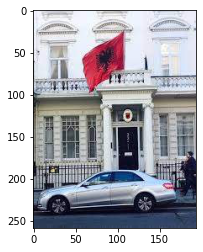

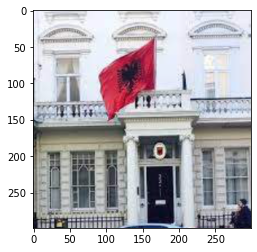

name
Afghanistan    0.179771
Albania        0.557819
Algeria        0.121844
Andorra        0.140566
dtype: float32
Albania


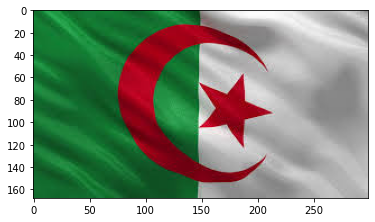

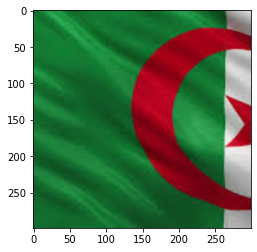

name
Afghanistan    0.223796
Albania        0.550035
Algeria        0.156782
Andorra        0.069387
dtype: float32
Albania


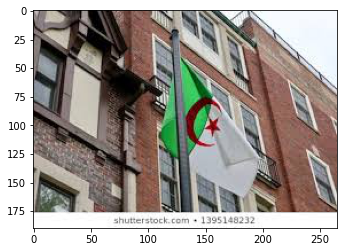

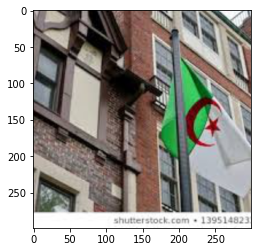

name
Afghanistan    0.068501
Albania        0.673412
Algeria        0.179011
Andorra        0.079076
dtype: float32
Albania


In [116]:
for example_fname in examples:
    example = mpimage.imread(example_fname)
    
    plt.imshow(example)
    plt.show()
    example = module.preprocess_input(example / 256)
    min_size = min(example.shape[:2])
    resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
    resized_example = np.expand_dims(resized_example, axis=0)
#     sns.distplot(resized_example)
#     plt.show()
    
    plt.imshow((resized_example[0] + 1) * 0.5 * 256)
    plt.show()
    preds = seq2.predict(resized_example)
    print(pd.Series(preds[0], index=df["name"][:len(preds[0])]))
    print(df["name"][preds.argmax()])

In [150]:
def test_img(img):
    pred = seq2.predict(np.expand_dims(img, axis=0))
    plt.imshow((img + 1) * 0.5 * 256 * 2)
    plt.show()
    return df["name"][pred.argmax()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


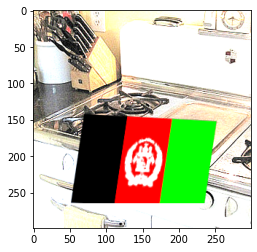

'Afghanistan'

In [151]:
test_img(batch[1])

In [95]:
idx = 3
print(df["name"][idx])
example = images[idx].copy()
min_size = min(example.shape[:2])
resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
resized_example = np.expand_dims(resized_example, axis=0)
preds = seq2.predict(resized_example)
print(preds)
df["name"][preds.argmax()]

Andorra
[[0.08446187 0.20791449 0.6222099  0.08541372]]


'Algeria'

[[0.2811368  0.4162582  0.19586994 0.10673512]]


'Albania'

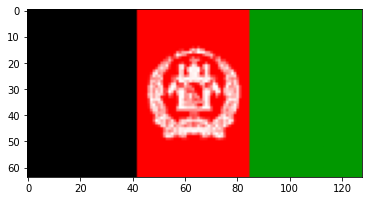

In [23]:
example = mpimage.imread(images_path + df["flag_128"][0])
plt.imshow(example)
example = module.preprocess_input(example)
min_size = min(example.shape[:2])
resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
resized_example = np.expand_dims(resized_example, axis=0)
preds = seq2.predict(resized_example)
print(preds)
df["name"][preds.argmax()]

[[0.19513468 0.5348442  0.18340904 0.0866121 ]]


'Albania'

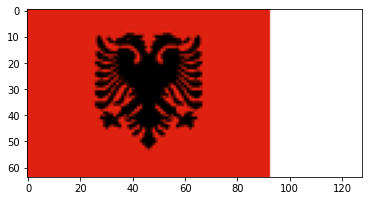

In [24]:
example = mpimage.imread(images_path + df["flag_128"][1])
plt.imshow(example)
example = module.preprocess_input(example[:, :, :3])
min_size = min(example.shape[:2])
resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
resized_example = np.expand_dims(resized_example, axis=0)
preds = seq2.predict(resized_example)
print(preds)
df["name"][preds.argmax()]

[[0.2668498  0.41846654 0.20621389 0.10846978]]


'Albania'

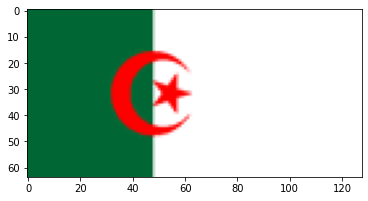

In [25]:
example = mpimage.imread(images_path + df["flag_128"][2])
plt.imshow(example)
example = module.preprocess_input(example[:, :, :3])
min_size = min(example.shape[:2])
resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
resized_example = np.expand_dims(resized_example, axis=0)
preds = seq2.predict(resized_example)
print(preds)
df["name"][preds.argmax()]

array([[0.2683446 , 0.46742687, 0.1577254 , 0.10650307]], dtype=float32)

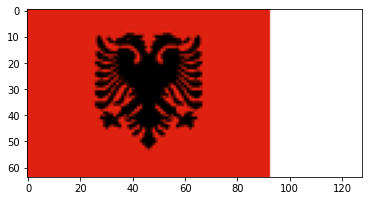

In [26]:
example = mpimage.imread(images_path + df["flag_128"][1])
plt.imshow(example)
example = module.preprocess_input(example[:, :, :3] / 255)
min_size = min(example.shape[:2])
resized_example = cv2.resize(example[:min_size, :min_size], (width, height))
resized_example = np.expand_dims(resized_example, axis=0)
seq2.predict(resized_example)

In [78]:
pred3 = seq2.predict(batch)

In [153]:
preds_batch.argmax(axis=1)

array([1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 1])

In [68]:
pred1 = seq2.call(tf.Variable(batch, dtype=tf.float32), training=True)
pred2 = seq2.call(tf.Variable(batch, dtype=tf.float32), training=False)
pred1 == pred2, pred3 == pred1

In [300]:
from keras import backend as K

In [371]:
K.set_learning_phase(1)

In [370]:
K.learning_phase()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


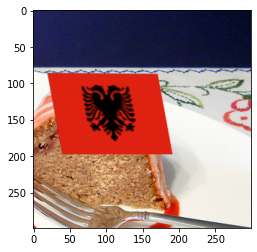

Predicted: 2 Algeria | Actual: 2 Algeria


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


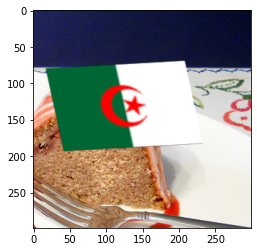

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 0 Afghanistan | Actual: 0 Afghanistan


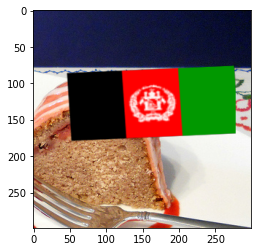

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 0 Afghanistan | Actual: 0 Afghanistan


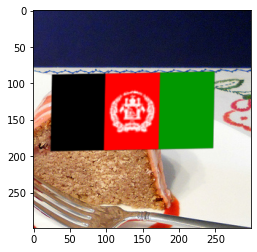

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 0 Afghanistan | Actual: 0 Afghanistan


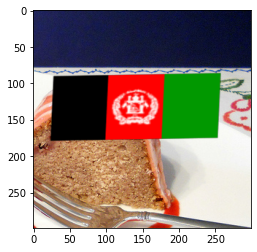

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 2 Algeria | Actual: 2 Algeria


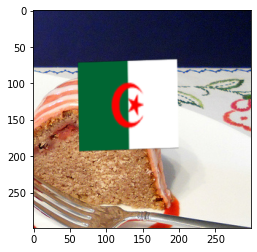

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 Andorra | Actual: 3 Andorra


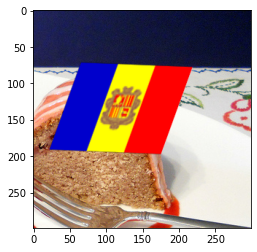

Predicted: 3 Andorra | Actual: 3 Andorra


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


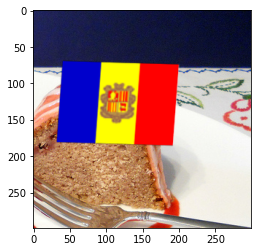

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 Andorra | Actual: 3 Andorra


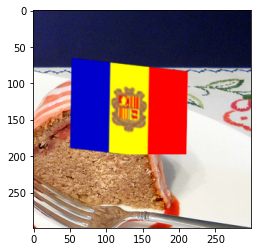

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 0 Afghanistan | Actual: 0 Afghanistan


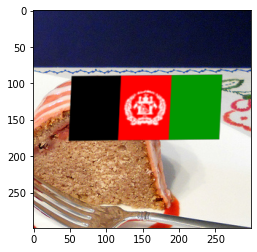

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 0 Afghanistan | Actual: 0 Afghanistan


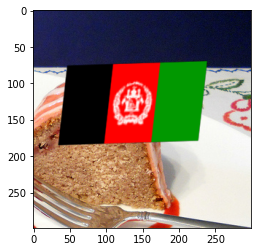

Predicted: 2 Algeria | Actual: 2 Algeria


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


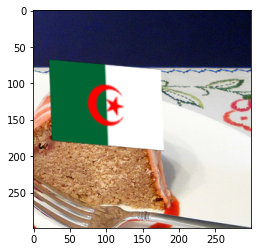

Predicted: 2 Algeria | Actual: 2 Algeria


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


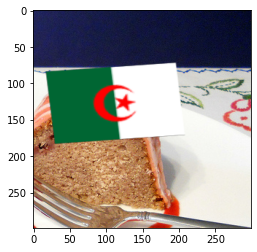

Predicted: 0 Afghanistan | Actual: 1 Albania


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


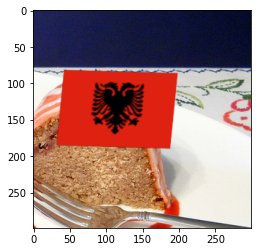

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 Andorra | Actual: 3 Andorra


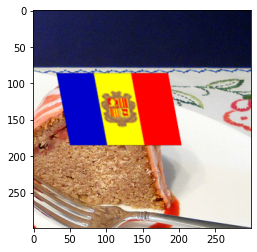

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


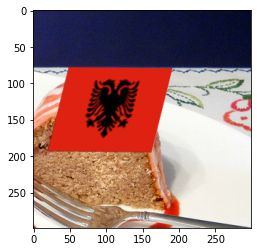

In [27]:
for i, im in enumerate(batch):
    pred_idx = preds_batch.argmax(axis=1)[i]
    act_idx = y_batch.argmax(axis=1)[i]
    print("Predicted:", pred_idx, df.loc[pred_idx]["name"], "| Actual:", act_idx, df.loc[act_idx]["name"])
    plt.imshow((im + 1) * 0.5 * 256)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 3 Andorra


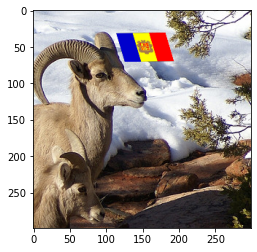

Predicted: 1 Albania | Actual: 1 Albania


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


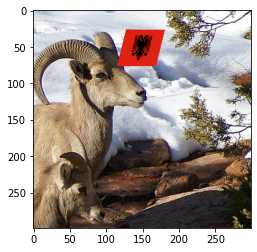

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 2 Algeria


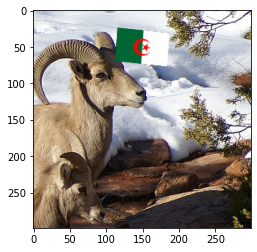

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


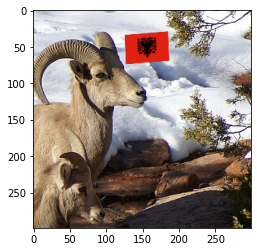

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 0 Afghanistan


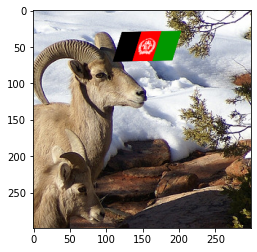

Predicted: 1 Albania | Actual: 0 Afghanistan


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


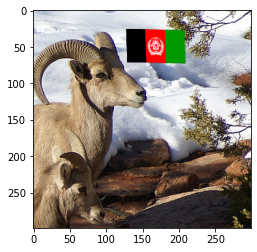

Predicted: 1 Albania | Actual: 2 Algeria


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


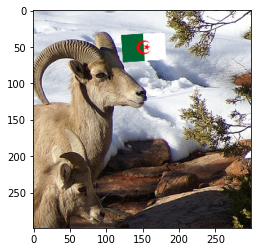

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 2 Algeria


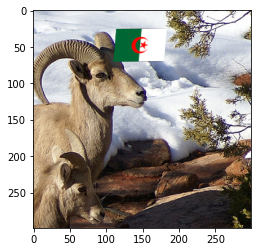

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 2 Algeria


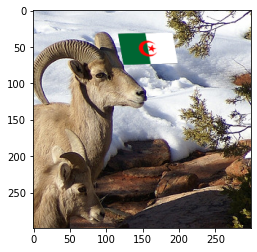

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 2 Algeria


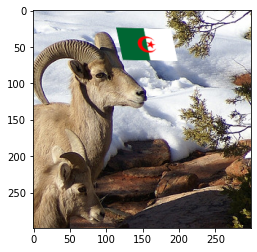

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


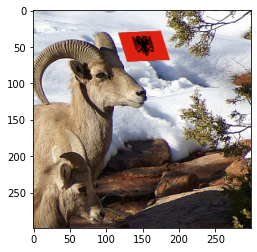

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


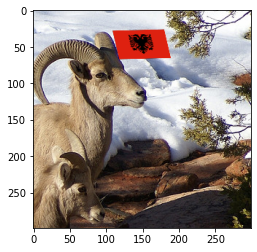

Predicted: 1 Albania | Actual: 1 Albania


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


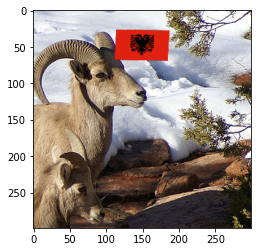

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 Albania | Actual: 1 Albania


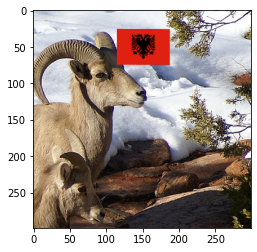

Predicted: 1 Albania | Actual: 1 Albania


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


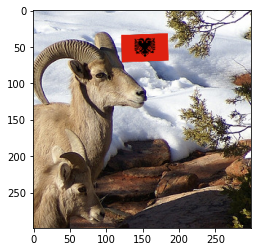

Predicted: 1 Albania | Actual: 2 Algeria


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


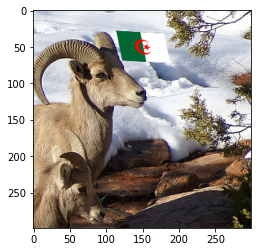

In [30]:
for i, im in enumerate(batch):
    pred_idx = preds_batch.argmax(axis=1)[i]
    act_idx = y_batch.argmax(axis=1)[i]
    print("Predicted:", pred_idx, df.loc[pred_idx]["name"], "| Actual:", act_idx, df.loc[act_idx]["name"])
    plt.imshow((im + 1) * 0.5 * 256)
    plt.show()

In [12]:
def train_gen(batch_size):
    while True:
        sample = random.sample(range(n_classes), batch_size)
        sample = [0]
        yield images[sample], y[sample]

In [110]:
batch_size = 2

In [85]:
seq2.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [86]:
seq2.fit_generator(train_gen(batch_size), validation_data=[images, y], epochs=10, steps_per_epoch=0.1 * 800//batch_size)

Epoch 1/10
40/40 [==============================] - 7s 168ms/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 2.3367 - val_accuracy: 0.5000
Epoch 2/10
40/40 [==============================] - 3s 82ms/step - loss: 1.0535e-05 - accuracy: 1.0000 - val_loss: 2.3779 - val_accuracy: 0.5000
Epoch 3/10
40/40 [==============================] - 3s 85ms/step - loss: 9.7960e-06 - accuracy: 1.0000 - val_loss: 2.3805 - val_accuracy: 0.5000
Epoch 4/10
40/40 [==============================] - 4s 90ms/step - loss: 9.6708e-06 - accuracy: 1.0000 - val_loss: 2.3825 - val_accuracy: 0.5000
Epoch 5/10
25/40 [=================>............] - ETA: 1s - loss: 9.5653e-06 - accuracy: 1.0000

KeyboardInterrupt: 

In [51]:
preds = seq2.predict(images)

In [25]:
idx_pred = pd.DataFrame(preds).idxmax(axis=1)

In [26]:
(idx_pred == idx_pred.index).mean()

0.5

In [27]:
idx_pred

0    0
1    0
dtype: int64

In [28]:
(y * np.log(preds)).sum() / n_classes

-0.8702804893255234

In [245]:
import random

In [250]:
list(images)[0].shape

(299, 299, 3)

In [251]:
images_lst = list(images)

In [100]:
mod_test = models.Sequential()
mod_test.add(BatchNormalization())
mod_test.compile(optimizer="adam", loss="mse")

In [173]:
mod_test.fit(img, img, epochs=100)

Epoch 1/100
299/299 [==============================] - 0s 55us/step - loss: 3.5830e-09
Epoch 2/100
299/299 [==============================] - 0s 55us/step - loss: 5.1950e-09
Epoch 3/100
299/299 [==============================] - 0s 59us/step - loss: 2.2476e-09
Epoch 4/100
299/299 [==============================] - 0s 53us/step - loss: 4.4330e-09
Epoch 5/100
299/299 [==============================] - 0s 58us/step - loss: 1.3644e-08
Epoch 6/100
299/299 [==============================] - 0s 60us/step - loss: 5.3276e-09
Epoch 7/100
299/299 [==============================] - 0s 56us/step - loss: 3.9540e-09
Epoch 8/100
299/299 [==============================] - 0s 52us/step - loss: 3.8519e-09
Epoch 9/100
299/299 [==============================] - 0s 52us/step - loss: 2.5697e-09
Epoch 10/100
299/299 [==============================] - 0s 52us/step - loss: 2.5437e-09
Epoch 11/100
299/299 [==============================] - 0s 52us/step - loss: 4.4069e-09
Epoch 12/100
299/299 [===================

In [161]:
a = mod_test.layers[0]
a.weights

[<tf.Variable 'batch_normalization_190/gamma:0' shape=(3,) dtype=float32, numpy=array([0.03180087, 0.03180738, 0.03183525], dtype=float32)>,
 <tf.Variable 'batch_normalization_190/beta:0' shape=(3,) dtype=float32, numpy=array([-0.99369246, -0.9972158 , -0.99748564], dtype=float32)>,
 <tf.Variable 'batch_normalization_190/moving_mean:0' shape=(3,) dtype=float32, numpy=array([-0.99374056, -0.9972685 , -0.9975391 ], dtype=float32)>,
 <tf.Variable 'batch_normalization_190/moving_variance:0' shape=(3,) dtype=float32, numpy=array([4.7411804e-06, 9.7673947e-06, 1.0937897e-05], dtype=float32)>]

In [174]:
mod_test.layers[0].get_weights()

[array([0.03170048, 0.03177727, 0.03179494], dtype=float32),
 array([-0.993739  , -0.99726814, -0.9975388 ], dtype=float32),
 array([-0.9937396 , -0.99726826, -0.9975389 ], dtype=float32),
 array([4.7349745e-06, 9.7667617e-06, 1.0937613e-05], dtype=float32)]

In [180]:
gamma, beta, mmean,mvar = mod_test.layers[0].get_weights()

In [181]:
pred_img = mod_test.predict(img)

In [182]:
((pred_img - img) ** 2).mean()

1.3701391e-13

In [188]:
(((img[:, :, 0] - mmean[0]) / ((mvar[0] + 0.001) ** 0.5)) * gamma[0] + beta[0] - pred_img[:, :, 0] ).min()

-5.9604645e-08

In [184]:
(((img[:, :, 0] - mmean[0]) / ((mvar[0] + 0.001) ** 0.5)) * gamma[0] + beta[0] - img[:, :, 0] )

array([[6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07],
       [6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07],
       [6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07],
       ...,
       [6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07],
       [6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07],
       [6.5565109e-07, 6.5565109e-07, 6.5565109e-07, ..., 7.1525574e-07,
        7.1525574e-07, 7.1525574e-07]], dtype=float32)

In [ ]:
(((img[:, :, 0] - mmean[0]) / ((mvar[0] + 0.001) ** 0.5)) * gamma[0] + beta[0] - pred_img[:, :, 0] )

In [163]:
mmean[0]

-0.9937453

In [164]:
mvar[0]

4.758958e-06

In [165]:
gamma[0]

0.04396372

In [170]:
 ((mvar[0] + 0.001) ** 0.5) / gamma[0]

0.7210020814421719

In [169]:
beta[0]

-0.9845544